In [1]:
import pickle
import numpy as np
import torch
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
use_gpu = torch.cuda.is_available()



def distribution_calibration(query, base_means, base_cov, k,alpha=0.21):
    dist = []
    for i in range(len(base_means)):
        dist.append(np.linalg.norm(query-base_means[i]))
    index = np.argpartition(dist, k)[:k]
    mean = np.concatenate([np.array(base_means)[index], query[np.newaxis, :]])
    calibrated_mean = np.mean(mean, axis=0)
    calibrated_cov = np.mean(np.array(base_cov)[index], axis=0)+alpha

    return calibrated_mean, calibrated_cov


if __name__ == '__main__':
    # ---- data loading
    dataset = 'CUB'
    n_shot = 5
    n_ways = 5
    n_queries = 20
    n_runs = 100
    n_lsamples = n_ways * n_shot
    n_usamples = n_ways * n_queries
    n_samples = n_lsamples + n_usamples


    import FSLTask
    cfg = {'shot': n_shot, 'ways': n_ways, 'queries': n_queries}
    FSLTask.loadDataSet(dataset)
    FSLTask.setRandomStates(cfg)
    ndatas = FSLTask.GenerateRunSet(end=n_runs, cfg=cfg)
    ndata_orign = FSLTask.GenerateOrigin(cfg = cfg)
    ndatas = ndatas.permute(0, 2, 1, 3).reshape(n_runs, n_samples, -1)
    labels = torch.arange(n_ways).view(1, 1, n_ways).expand(n_runs, n_shot + n_queries, 5).clone().view(n_runs,
                                                                                                        n_samples)
    # ---- Base class statistics
    base_means = []
    base_cov = []
    X_aug = []
    Y_aug = []
    support_data = []
    sampled_data = []
    base_features_path = ./filelists/%s/base_features.plk"%dataset      # /WideResNet28_10_S2M2_R/last
    with open(base_features_path, 'rb') as f:
        data = pickle.load(f)
        for key in data.keys():
            feature = np.array(data[key])
            mean = np.mean(feature, axis=0)
            cov = np.cov(feature.T)
            base_means.append(mean)
            base_cov.append(cov)

    # ---- classification for each task
    acc_list = []
    print('Start classification for %d tasks...'%(n_runs))
    for i in tqdm(range(n_runs)):

        support_data = ndatas[i][:n_lsamples].numpy()
        support_label = labels[i][:n_lsamples].numpy()
        query_data = ndatas[i][n_lsamples:].numpy()
        query_label = labels[i][n_lsamples:].numpy()
        # ---- Tukey's transform
        # beta = 2  # -1 to 1
        # support_data = np.power(support_data[:, ] , beta)
        # query_data = np.power(query_data[:, ] , beta)
        # ---- distribution calibration and feature sampling
        sampled_data = []
        sampled_label = []
        num_sampled = int(750/n_shot)
        # without DC
        for i in range(n_lsamples):
            mean, cov = distribution_calibration(support_data[i], base_means, base_cov, k=2)
            sampled_data.append(np.random.multivariate_normal(mean=mean, cov=cov, size=num_sampled))
            sampled_label.extend([support_label[i]]*num_sampled)
        sampled_data = np.concatenate([sampled_data[:]]).reshape(n_ways * n_shot * num_sampled, -1)
        X_aug = np.concatenate([support_data, sampled_data])
        Y_aug = np.concatenate([support_label, sampled_label])
        # X_aug = support_data
        # Y_aug = support_label
        # ---- train classifier
        classifier = LogisticRegression(max_iter=1000).fit(X=X_aug, y=Y_aug)



        predicts = classifier.predict(query_data)
        acc = np.mean(predicts == query_label)
        acc_list.append(acc)
    print('%s %d way %d shot  ACC : %f'%(dataset,n_ways,n_shot,float(np.mean(acc_list))))



Guaranteed number of items per class: 48

Total of 50 classes, 48 elements each, with dimension 640

reloading random states from file....
generating task from 0 to 100
Start classification for 100 tasks...


100%|██████████| 100/100 [18:05<00:00, 10.85s/it]

CUB 5 way 5 shot  ACC : 0.892600


In [2]:
    X_aug_train = X_aug 
    Y_aug_train = Y_aug

In [3]:
print(ndata_orign.shape)

torch.Size([5, 48, 640])


In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
ndata_orign = FSLTask.GenerateOrigin(cfg = cfg)


x_plot_0 = ndata_orign[0,:,:]
x_plot_1 = ndata_orign[1,:,:]
x_plot_2 = ndata_orign[2,:,:]
x_polt_3 = ndata_orign[3,:,:]
x_plot_4 = ndata_orign[4,:,:]

X_origin = np.concatenate([support_data,x_plot_0,x_plot_1,x_plot_2,x_polt_3,x_plot_4])
Y_origin = []


for i in range(5): 
    Y_zero = np.full((48), i)  #48 600
    Y_origin = np.concatenate([Y_origin,Y_zero])
    
Y_origin = np.concatenate([support_label,Y_origin])
# pca = PCA(n_components=2)
# x_plot_origin=pca.fit_transform(X_origin)


tsne = TSNE(n_components=2)
tsne.fit_transform(X_origin)


x_plot_origin = tsne.embedding_ 

# print(x_plot_origin.shape)



In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


x_plot_0 = []
x_plot_1 = []
x_plot_2 = []
x_polt_3 = []
x_plot_4 = []

x_plot_o_0 = []
x_plot_o_1 = []
x_plot_o_2 = []
x_plot_o_3 = []
x_plot_o_4 = []

X_aug = X_aug_train
Y_aug = Y_aug_train

# pca = PCA(n_components=2)
# x_plot=pca.fit_transform(X_aug)#


tsne = TSNE(n_components=2)
tsne.fit_transform(X_aug)


x_plot = tsne.embedding_ 



# X_compose = np.concatenate([X_origin,X_aug])

# # pca = PCA(n_components=2)
# # x_copose=pca.fit_transform(X_compose)#
# tsne = TSNE(n_components=2)
# tsne.fit_transform(X_compose)
# x_copose = tsne.embedding_ 

# x_plot_origin = x_copose[:X_origin.shape[0]]
# x_plot = x_copose[-X_aug.shape[0]:,:]


for i in range(x_plot.shape[0]):
    if Y_aug[i] ==0:
        x_plot_0.append(x_plot[i])
    if Y_aug[i] ==1:
        x_plot_1.append(x_plot[i])
    if Y_aug[i] ==2:
        x_plot_2.append(x_plot[i])
    if Y_aug[i] ==3:
        x_polt_3.append(x_plot[i])
    if Y_aug[i] ==4:
        x_plot_4.append(x_plot[i])



In [6]:
print(X_origin.shape)

(265, 640)


In [7]:

for i in range(x_plot_origin.shape[0]):
    if Y_origin[i] ==0:
        x_plot_o_0.append(x_plot_origin[i])
    if Y_origin[i] ==1:
        x_plot_o_1.append(x_plot_origin[i])
    if Y_origin[i] ==2:
        x_plot_o_2.append(x_plot_origin[i])
    if Y_origin[i] ==3:
        x_plot_o_3.append(x_plot_origin[i])
    if Y_origin[i] ==4:
        x_plot_o_4.append(x_plot_origin[i])


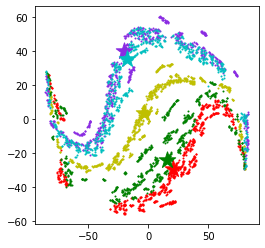

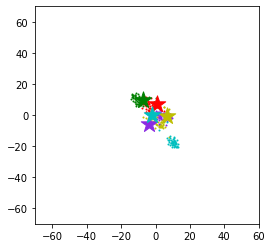

In [8]:
import numpy as np
import matplotlib.pyplot as plt

s_ = 300
marker_ = "*"

x_plot_0 = np.array(x_plot_0)
x_plot_1 = np.array(x_plot_1)
x_plot_2 = np.array(x_plot_2)
x_plot_3 = np.array(x_polt_3)
x_plot_4 = np.array(x_plot_4)

x_plot_o_0 = np.array(x_plot_o_0)
x_plot_o_1 = np.array(x_plot_o_1)
x_plot_o_2 = np.array(x_plot_o_2)
x_plot_o_3 = np.array(x_plot_o_3)
x_plot_o_4 = np.array(x_plot_o_4)

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(x_plot_0[:,0], x_plot_0[:,1], c="y", s=1)
ax.scatter(x_plot_1[:,0], x_plot_1[:,1], c="r", s=1)
ax.scatter(x_plot_2[:,0], x_plot_2[:,1], c="blueviolet", s=1)
ax.scatter(x_plot_3[:,0], x_plot_3[:,1], c="g", s=1)
ax.scatter(x_plot_4[:,0], x_plot_4[:,1], c="c", s=1)

ax.scatter(x_plot_0[0,0], x_plot_0[0,1], c="y",marker=marker_, s=s_)
ax.scatter(x_plot_1[0,0], x_plot_1[0,1], c="r",marker=marker_, s=s_)
ax.scatter(x_plot_2[0,0], x_plot_2[0,1], c="blueviolet",marker=marker_, s=s_)
ax.scatter(x_plot_3[0,0], x_plot_3[0,1], c="g",marker=marker_, s=s_)
ax.scatter(x_plot_4[0,0], x_plot_4[0,1], c="c",marker=marker_, s=s_)


# for i in range(5):
fig, ax = plt.subplots(figsize=(4,4))
plt.xlim(-70, 60)
plt.ylim(-70, 70)
ax.scatter(x_plot_o_0[:,0], x_plot_o_0[:,1], c="y", s=1)
ax.scatter(x_plot_o_1[:,0], x_plot_o_1[:,1], c="r", s=1)
ax.scatter(x_plot_o_2[:,0], x_plot_o_2[:,1], c="blueviolet", s=1)
ax.scatter(x_plot_o_3[:,0], x_plot_o_3[:,1], c="g", s=1)
ax.scatter(x_plot_o_4[:,0], x_plot_o_4[:,1], c="c", s=1)

ax.scatter(x_plot_o_0[0,0], x_plot_o_0[0,1], c="y",marker=marker_, s=s_)
ax.scatter(x_plot_o_1[0,0], x_plot_o_1[0,1], c="r",marker=marker_, s=s_)
ax.scatter(x_plot_o_2[0,0], x_plot_o_2[0,1], c="blueviolet",marker=marker_, s=s_)
ax.scatter(x_plot_o_3[0,0], x_plot_o_3[0,1], c="g",marker=marker_, s=s_)
ax.scatter(x_plot_o_4[0,0], x_plot_o_4[0,1], c="c",marker=marker_, s=s_)

